# Name Classification

In this notebook, we'll be creating a simple model for classifying names based upon language. For example: `Schmidhuber` sounds more like a name in the `German language`, whereas `Hinton` sounds more like a name in the `Scottish language`.

## Imports


In [1]:
import os
import unicodedata, string
from glob import glob
import torch
import torch.nn as nn

## Dataset

The dataset contains of 18 text files named as “[Language].txt”. Each file contains a bunch of names, one name per line, mostly romanized.

In [2]:
all_categories = []
category_lines = {}

In [3]:
# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def read_file(fpath):
    lines = open(fpath, "r").read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

In [4]:
# Read language names into array, and {language: [names]} into a dictionary
for fpath in glob("./data/names/*.txt"):
    category = os.path.basename(fpath).split(".txt")[0]
    all_categories.append(category)
    lines = read_file(fpath)
    category_lines[category] = lines

In [5]:
all_categories

['Czech',
 'German',
 'Arabic',
 'Japanese',
 'Chinese',
 'Vietnamese',
 'Russian',
 'French',
 'Irish',
 'English',
 'Spanish',
 'Greek',
 'Italian',
 'Portuguese',
 'Scottish',
 'Dutch',
 'Korean',
 'Polish']

In [6]:
category_lines["German"][:5]

['Abbing', 'Abel', 'Abeln', 'Abt', 'Achilles']

## Turning Names into Tensor

To convert names into tensors, we split names into characters and represent each character as a `One Hot Encoded` vector representation of size `<1 x n_letters>`. Then, to make a word we join a bunch of these representations into a 2D matrix of size `<word_length, 1, n_letters>`.

For example: 

A word `ape` can be represented in One Hot Vector as follows:

```
a b c d e f g h i j k l m n o p q r s t u v w x y z

1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

Shape: [3, 1, 26]
```

**Note:**

1. In the example above, `1` represents the batch size. Since, we are using only 1 word, the batch size is 1. 
2. Also, the 26 in n_letters used above is when only considering characters from a to z. In practice, we'll have characters from `a to z`, `A to Z` and special characters ` .,;'`.

In [7]:
# Helper Functions

# Get index of letter
def letterToIndex(letter):
    return all_letters.find(letter)


def letterToTensor(letter):
    ohe_letter = torch.zeros(1, n_letters)
    ohe_letter[0][letterToIndex(letter)] = 1
    
    return ohe_letter


# Function to convert Word to OHE Tensor
def lineToTensor(line):
    # Initialize word tensor with zeros
    ohe_word = torch.zeros(len(line), 1, n_letters)
    
    # Go through all letters in the word and set to 1 
    # corresponding to index of letter in word
    for idx, letter in enumerate(line):
        ohe_word[idx][0][letterToIndex(letter)] = 1
    
    return ohe_word

In [8]:
# Test
print("letterToIndex: ", letterToIndex('J'))
print(f"lineToTensor: {lineToTensor('ape')}, \nshape: {lineToTensor('ape').shape}")

letterToIndex:  35
lineToTensor: tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]]]), 
shape: torch.Size([3, 1, 57])


## Creating the Network

Here, we'll create a simple RNN model first for performing classification.

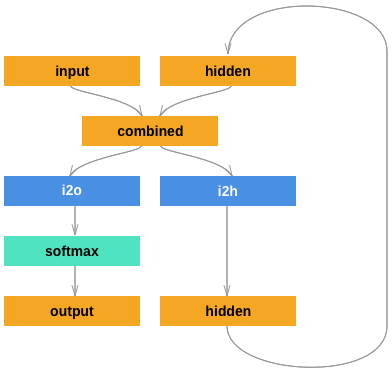

In [9]:
class RNN(nn.Module):
    def __init__(self, in_size, hidden_size, out_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        # Combined Layer Output = input + hidden
        self.i2o = nn.Linear(in_features=in_size + hidden_size, out_features=out_size)
        self.i2h = nn.Linear(in_features=in_size + hidden_size, out_features=hidden_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden):
        # print(f"in: {input}, shape: {input.shape}")
        # print(f"\nhidden_prev: {hidden}, shape: {hidden.shape}")
        
        combined = torch.cat((input, hidden), 1)
        # print(f"\ncombined: {combined}, shape: {combined.shape}")
        
        hidden = self.i2h(combined)
        # print(f"\nhidden_next: {hidden}, shape: {hidden.shape}")
        
        output = self.softmax(self.i2o(combined))
        # print(f"\noutput: {output}, shape{output.shape}")
        
        return output, hidden
    
    # Initialize Hidden Layer with Zeros
    def initHidden(self):
        return torch.zeros((1, self.hidden_size))

In [10]:
n_categories = len(all_categories)
n_hidden = 128

rnn = RNN(in_size=n_letters, hidden_size=n_hidden, out_size=n_categories)
print(rnn)

RNN(
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [11]:
# TEST: One Character as Input
input = letterToTensor("A")
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)
print(f"output: {output.shape}, next_hidden: {next_hidden.shape}")

output: torch.Size([1, 18]), next_hidden: torch.Size([1, 128])


In [12]:
# TEST: Full Word as Input
input = lineToTensor("Anuj")
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(f"output: {output}, shape: {output.shape}")
print(f"\nnext_hidden: {next_hidden}, shape: {next_hidden.shape}")

output: tensor([[-2.9388, -3.0059, -2.9733, -2.9006, -2.9282, -2.9148, -2.9378, -2.9886,
         -2.8060, -2.9766, -2.8329, -2.8388, -2.8630, -2.8619, -2.8397, -2.7695,
         -2.8216, -2.8692]], grad_fn=<LogSoftmaxBackward0>), shape: torch.Size([1, 18])

next_hidden: tensor([[ 0.0414, -0.0731,  0.0592, -0.0429, -0.0566,  0.0569, -0.0497, -0.0544,
          0.0060, -0.0199, -0.0488, -0.0314, -0.0628,  0.0467, -0.0380, -0.0885,
          0.0154,  0.0218,  0.0203,  0.1115,  0.0593,  0.0402,  0.0780,  0.0087,
         -0.0194, -0.0370, -0.0160,  0.1268, -0.0216, -0.0432, -0.0152,  0.0408,
          0.0953,  0.0616,  0.0712, -0.0235, -0.0072,  0.1011,  0.0773,  0.0185,
         -0.1373,  0.0080,  0.0302, -0.0574, -0.0644,  0.1190,  0.1007, -0.0246,
          0.0928, -0.0052,  0.0865, -0.0494, -0.0088,  0.0452,  0.0240,  0.0438,
         -0.0140,  0.0085,  0.0051, -0.0641, -0.0378, -0.0622,  0.0122, -0.0484,
          0.1204,  0.0523,  0.0057, -0.0035,  0.0116,  0.0102,  0.0568, -0.0564,

As we can see the output is a `<1 x n_categories>` Tensor, where every item is the likelihood of that category (higher is more likely).

## Training

Before going into training we should make a few helper functions. The first is to interpret the output of the network, which we know to be a likelihood of each category. We can use `Tensor.topk` to get the index of the greatest value:

In [13]:
def categoryFromOutput(output):
    # Index of top-1 probability from predictions
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    
    return all_categories[category_i], category_i

In [14]:
# Predicted label & category index
print(categoryFromOutput(output))

('Dutch', 15)


In [15]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    # Pick a category at random from all categories
    category = randomChoice(all_categories)
    
    # Get random name from the selected category
    line = randomChoice(category_lines[category])
    
    # GT Label - Category Tensor containing index of categories
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    
    # Create a One Hot Encoded Tensor corresponding to the characters
    # in the random name selected from a random category
    # Shape = (len(word), 1, total_number_of_letters)
    line_tensor = lineToTensor(line)
    
    return category, line, category_tensor, line_tensor


for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line, '/ category_tensor_shape =', category_tensor.shape, '/ line_tensor_shape =', line_tensor.shape)

category = Czech / line = Cermak / category_tensor_shape = torch.Size([1]) / line_tensor_shape = torch.Size([6, 1, 57])
category = Russian / line = Yatzyshin / category_tensor_shape = torch.Size([1]) / line_tensor_shape = torch.Size([9, 1, 57])
category = German / line = Grosz / category_tensor_shape = torch.Size([1]) / line_tensor_shape = torch.Size([5, 1, 57])
category = Italian / line = Lama / category_tensor_shape = torch.Size([1]) / line_tensor_shape = torch.Size([4, 1, 57])
category = Chinese / line = Yep / category_tensor_shape = torch.Size([1]) / line_tensor_shape = torch.Size([3, 1, 57])
category = English / line = Robbins / category_tensor_shape = torch.Size([1]) / line_tensor_shape = torch.Size([7, 1, 57])
category = Spanish / line = Suarez / category_tensor_shape = torch.Size([1]) / line_tensor_shape = torch.Size([6, 1, 57])
category = Polish / line = Kaluza / category_tensor_shape = torch.Size([1]) / line_tensor_shape = torch.Size([6, 1, 57])
category = English / line = Gi

In [16]:
# Loss
criterion = nn.NLLLoss()

Each loop of training will:

1. Create input and target tensors
2. Create a zeroed initial hidden state
3. Read each letter in and
4. Keep hidden state for next letter
5. Compare final output to target
6. Back-propagate the loss
7. Return the output and loss

In [17]:
# Learning Rate
lr = 0.005

def train(category_tensor, line_tensor):
    """
        category_tensor: Ground Truth tensor containing the index of language category
        line_tensor: Tensor containing One Hot Encoded characters in a word
    """
    
    # Initial Hidden State - torch.zero() tensor
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    # Pass in OHE tensor for each word, character by character
    for i in range(line_tensor.size()[0]):
        # Output and next hidden state
        output, hidden = rnn(line_tensor[i], hidden)
    
    loss = criterion(output, category_tensor)
    loss.backward()
    
    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-lr)
    
    return output, loss.item()

In [18]:
import time
import math

In [19]:
n_iters = 100000
print_every = 5000
plot_every = 1000

In [20]:
# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [21]:
start = time.time()

for iter in range(1, n_iters + 1):
    # Get a tensor for a random word and corresponding Ground truth category Tensor
    category, line, category_tensor, line_tensor = randomTrainingExample()
    
    # Train the Model, returns output at current timestep & next hidden state
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 3s) 2.4079 Amerighi / Dutch ✗ (Italian)
10000 10% (0m 6s) 1.3826 Nam / Chinese ✗ (Korean)
15000 15% (0m 9s) 2.1845 D'cruz / Spanish ✗ (Portuguese)
20000 20% (0m 12s) 3.4283 Amador / Russian ✗ (Spanish)
25000 25% (0m 15s) 0.7827 Hishida / Japanese ✓
30000 30% (0m 19s) 1.4981 Sokolof / Czech ✗ (Polish)
35000 35% (0m 22s) 2.8204 Gonzalez / Spanish ✗ (English)
40000 40% (0m 25s) 1.6948 Urbina / Italian ✗ (Spanish)
45000 45% (0m 28s) 0.7381 Podolinsky / Russian ✓
50000 50% (0m 31s) 0.2599 Riagan / Irish ✓
55000 55% (0m 35s) 0.8771 Murray / Scottish ✓
60000 60% (0m 38s) 0.8228 Makino / Japanese ✓
65000 65% (0m 42s) 1.3310 Greenberg / Dutch ✗ (German)
70000 70% (0m 45s) 3.8880 Vandale / French ✗ (Dutch)
75000 75% (0m 49s) 3.2326 Gaspar / Portuguese ✗ (Spanish)
80000 80% (0m 52s) 2.9876 Sessa / Czech ✗ (Italian)
85000 85% (0m 56s) 0.6299 Gong / Chinese ✓
90000 90% (0m 59s) 0.2075 Khoury / Arabic ✓
95000 95% (1m 2s) 2.5050 Baumbach / French ✗ (German)
100000 100% (1m 6s) 3.0053 Alma

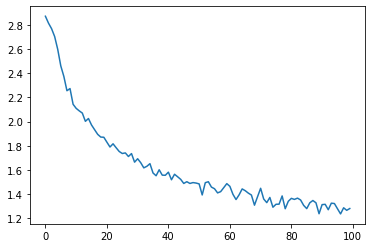

In [22]:
# Plotting the Training Results
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## Evaluate Trained Model

In [23]:
# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

In [24]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

In [25]:
# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

/var/folders/rk/3j211bj53lb3k3wgfh02x3p80000gn/T/ipykernel_5565/1733772511.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/var/folders/rk/3j211bj53lb3k3wgfh02x3p80000gn/T/ipykernel_5565/1733772511.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


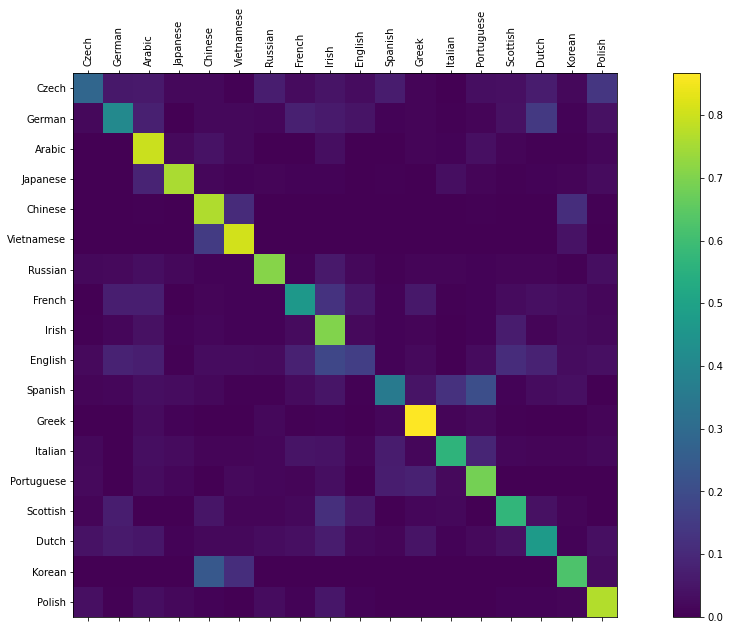

In [26]:
# Set up plot
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

## Inferencing on User Input

In [27]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [28]:
predict('Jackson')


> Jackson
(-0.34) Scottish
(-2.09) English
(-3.02) Russian


In [29]:
predict('Satoshi')


> Satoshi
(-1.09) Japanese
(-1.69) Arabic
(-1.89) Italian
